In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import pdb
import sys
sys.path.insert(0, '/home/andrea/Scrivania/Tesi/leonardo')
from data import dataset
from trainer import Trainer
from models.GCN_LSTM.model import GCN_LSTM

In [2]:
with open("/home/andrea/Scrivania/Tesi/leonardo/config_env.yaml", 'r') as f:
    config_env = yaml.safe_load(f)

id_model = "GCN-LSTM"
with open(os.path.join(config_env['paths']['config'], f"{id_model}.yaml"), 'r') as f:
    config = yaml.safe_load(f)
    
config.update(config_env)

if 'epochs' in config_env['setting'].keys():
    config['training']['epochs'] = config_env['setting']['epochs']


In [3]:
data = pd.read_csv(os.path.join(config['paths']['data'], 'covid.csv'), index_col=0)
data.data = pd.to_datetime(data.data, format="%Y-%m-%d %H:%M:%S.%f")
data.rename(columns = {'nuovi_casi':'y'}, inplace=True)

In [7]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']
if os.path.exists(os.path.join(config['paths']['data'],config['setting']['dataset'],f"{config['setting']['dataset']}_{past_step}_{future_step}.pkl")):
    with open(os.path.join(config['paths']['data'], config['setting']['dataset'],f"{config['setting']['dataset']}_{past_step}_{future_step}.pkl"), 'rb') as f:
        ds = pickle.load(f)
else:
    with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "rb") as f:
        adj = pickle.load(f)
    ds = dataset(df = data, 
            past_step = past_step,
            future_step = future_step, 
            nodes = len(data.codice_provincia.unique()),
            adj = adj, 
            timedelta = 'D')
    with open(os.path.join(config['paths']['data'], config['setting']['dataset'],f"{config['setting']['dataset']}_{past_step}_{future_step}.pkl"), 'wb') as f:
        pickle.dump(ds, f)


In [13]:

class dataset(Dataset):
    
    def __init__(self, 
                 df:pd,
                 adj: np.array,
                 nodes: int, 
                 past_step:int, 
                 future_step:int, 
                 timedelta:str,
                 categorical_variables: list, 
                 col_data: str = "data"):
        """
        Arguments:
            df (pandas.Dataframe): Path to the csv file with annotations.
            adj : adjacency matrix
            nodes : number of nodes
            past_step (int): previous step to look back
            future_step (int): future step to look for
            col_data (str): it indicate the columns that gives the indication about the time
        """

        self.x = []
        self.x_fut = []
        self.y = []
        self.adj = adj
        date = df[col_data].unique()
        date.sort()
        start = 0
        dt = np.diff(date[:past_step+future_step]) == np.timedelta64(1, timedelta)
        while any(not x for x in dt):
            start +=1
            dt = np.diff(date[start:past_step+future_step+ start]) == np.timedelta64(1, timedelta)
        
        for i in tqdm(range(start, len(date)-future_step-past_step-1)):
            if date[i+past_step+future_step]-date[i+past_step+future_step-1] == np.timedelta64(1, timedelta): 
                tmp_x = df[df[col_data].isin(date[i:i+past_step])].drop(columns = col_data).values
                tmp_y = df[df[col_data].isin(date[i+past_step:i+past_step+future_step])]
                
                self.x_fut.append(tmp_y[categorical_variables].values.reshape(future_step, nodes, -1))
                self.x.append(tmp_x.reshape(past_step, nodes, -1))
                self.y.append(tmp_y.y.values.reshape(future_step, -1))
            else:
                i += past_step+future_step
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.x_fut[idx], self.y[idx], self.adj

In [ ]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']
with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "rb") as f:
    adj = pickle.load(f)
ds = dataset(df = data, 
            past_step = past_step,
            future_step = future_step, 
            nodes = len(data.codice_provincia.unique()),
            categorical_variables = data.columns[-7:].tolist(), 
            adj = adj, 
            timedelta = 'D')

 73%|████████████████████████████▍          | 885/1215 [00:05<00:01, 186.78it/s]

In [8]:
len_train = int(len(ds)*0.75)
len_val = len(ds)-len_train
batch_size = 32
df_train, df_val = torch.utils.data.random_split(dataset=ds, lengths = [len_train, len_val])
dl_train = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset=df_val, batch_size=batch_size, shuffle=True)
batch, y, adj = next(iter(dl_train))
print(batch.shape)
print(y.shape)

torch.Size([32, 30, 107, 23])
torch.Size([32, 50, 107])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = GCN_LSTM(in_feat = batch.shape[-1], 
                  past = past_step,
                  future = future_step,
                  categorical = config['model']['categorical'],
                  device = device).to(device)

GCN_LSTM


In [10]:
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-4, 
                       weight_decay=2e-4)

def linfty(y, yh, gamma = 1.0, alpha=1e-1, beta=1e-0):
    out = 0.5*F.l1_loss(y,yh, reduction = "mean")
    out += gamma*F.mse_loss(y,yh, reduction = "mean")
    out += alpha*torch.max(torch.abs(y-yh))
    out += beta*(torch.sum(F.relu(-yh)))
    return out

In [11]:
trainer = Trainer(model = model.to(device), 
                  PATH = os.path.join(config['paths']['models'], "testing.pt"), 
                  optimizer = optimizer, 
                  gamma_scheduler = 0.85, 
                  step= 300, 
                  loss_function = linfty)

trainer.fit(train_loader=dl_train, val_loader=dl_val, epochs=2)

  0%|                                                     | 0/2 [00:00<?, ?it/s]


RuntimeError: diag(): Supports 1D or 2D tensors. Got 0D

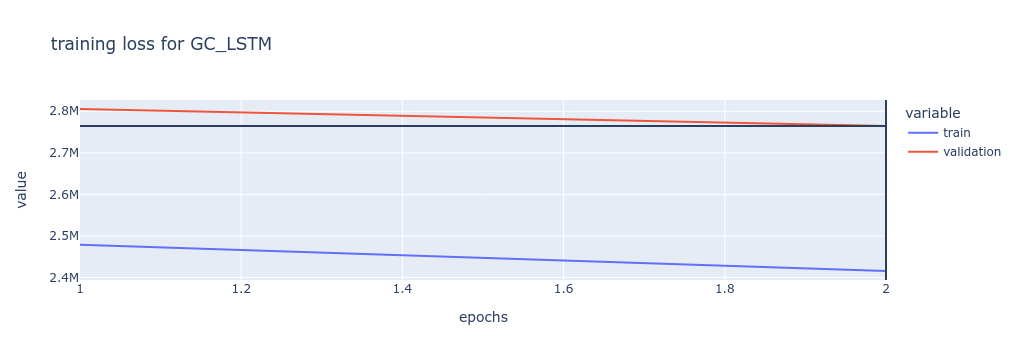

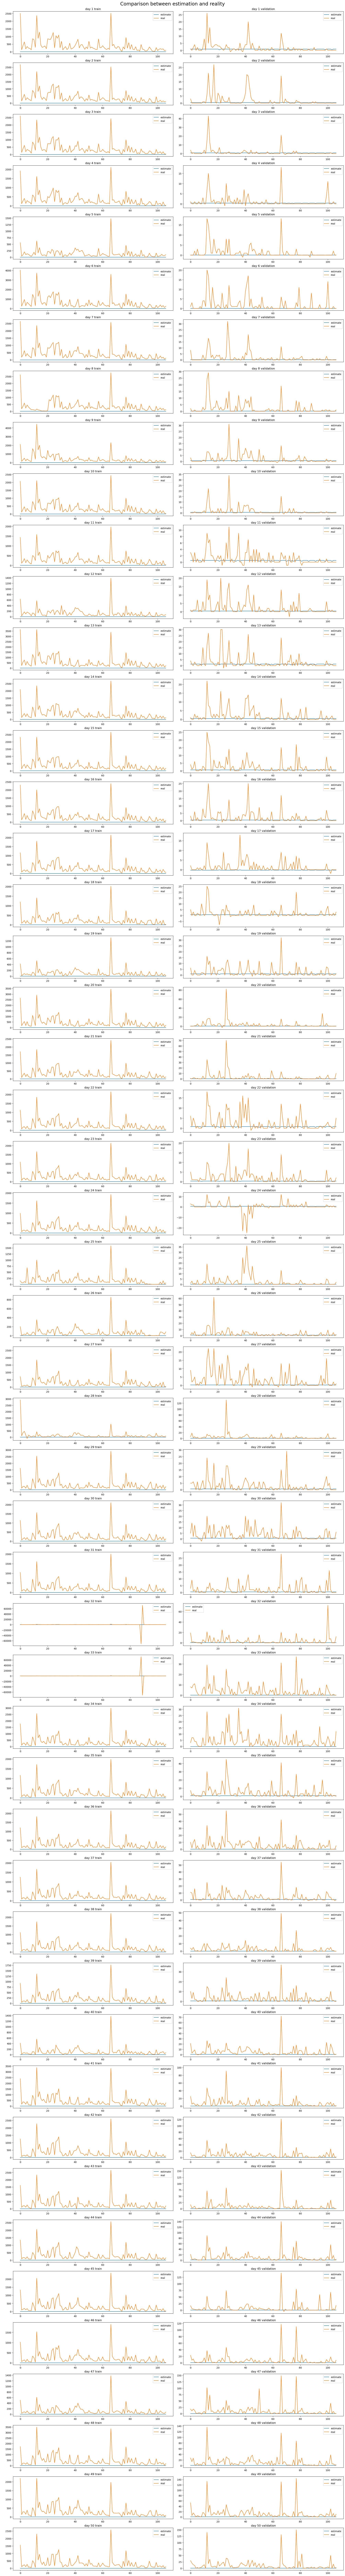

In [15]:


id_model = "GC_LSTM"
plot(model = trainer.model,
     config = config,
     loss_training = trainer.loss_train, 
     loss_validation = trainer.loss_val, 
     dl_train = dl_train, 
        dl_val = dl_val, 
        name = f"{id_model}", 
        show = True)

In [ ]:
def plot_stream(model, 
         config,
         loss_training, 
         loss_validation, 
         name,
         time_step:int, 
         data:pd.DataFrame, 
         show = False):
    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'], f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    
    past_step = model.past
    future_step = model.future
    date = np.sort(data.data.unique())
    y = []
    yh = []
    x_date = []
    start = 0
    dt = np.diff(date[:past_step+future_step]) == np.timedelta64(1, timedelta)
    while any(not x for x in dt):
        start +=1
        dt = np.diff(date[start:past_step+future_step+ start]) == np.timedelta64(1, timedelta)
    
    for i in tqdm(range(start, len(date)-future_step-past_step-1)):
        if date[i+past_step+future_step]-date[i+past_step+future_step-1] == np.timedelta64(1, timedelta): 
            x = data[data.data.isin(date[i:i+past_step])].drop(columns = 'data').values
            x = x.reshape(1, past_step, n_nodes, config['setting']['in_feat'])
            tmp = data[data.data.isin(date[i+past_step:i+past_step+future_step])].y.values
            y.append(tmp.reshape(1, future_step, n_nodes))
            yh.append(F.relu(model(torch.from_numpy(x).to(model.device), adj[0].to(model.device)).detach()).cpu())
        else:
             i += past_step+future_step 
    
    yh = torch.cat(yh,0)
    y = np.vstack(y) 
    f = y.shape[-1]
    for step in range(model.future):
        fig, ax = plt.subplots(nrows = f, 
                                   ncols = 1, 
                                   constrained_layout = True,
                                   figsize = (20,f*3))
    
        for n in range(f):
            ax[n].plot(y[:,step,n], label = 'real')
            ax[n].plot(yh[:,step, n], label = 'estimated')
            ax[n].legend()  

            err = np.mean(np.abs(yh[:,step, n].numpy()-y[:,step, n]))
            ax[n].title.set_text(f"node {n}, step {step} train, err = {err}")
        
        path = os.path.join(config['paths']['fig_flows'], f"{name}", f"step{step+1}.png")
        plt.savefig(path)
        plt.close()


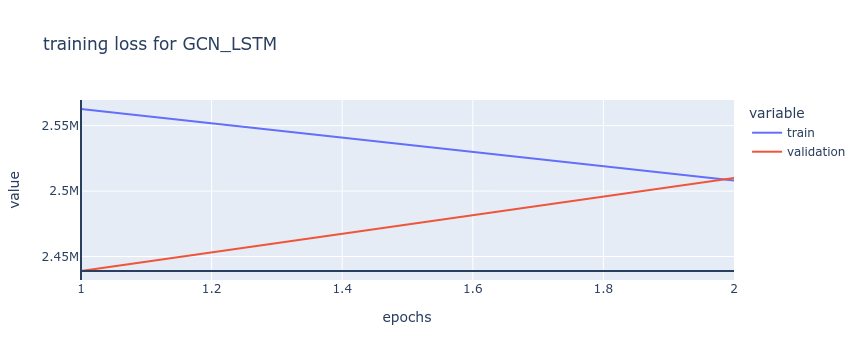

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 43.76it/s]

KeyboardInterrupt



Error in callback <function flush_figures at 0x7fa7cad299e0> (for post_execute):



KeyboardInterrupt



In [67]:
plot_stream(trainer.model,
     config,
     trainer.loss_train, 
     trainer.loss_val, 
     name = "GCN_LSTM", 
     time_step = 3, 
     data = data, 
     show = True)